In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN

from collections import Counter
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv('dataset.csv')

In [13]:
df.describe().transpose()

,count,unique,top,freq
Systemic Illness,25000,4,Fever,6382
Rectal Pain,25000,2,False,12655
Sore Throat,25000,2,True,12554
Penile Oedema,25000,2,True,12612
Oral Lesions,25000,2,False,12514
Solitary Lesion,25000,2,True,12527
Swollen Tonsils,25000,2,True,12533
HIV Infection,25000,2,True,12584
Sexually Transmitted Infection,25000,2,False,12554
MonkeyPox,25000,2,Positive,15909


In [21]:
df = df.drop( "Patient_ID", axis=1)

In [22]:
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())


Data Types:
Systemic Illness                  object
Rectal Pain                         bool
Sore Throat                         bool
Penile Oedema                       bool
Oral Lesions                        bool
Solitary Lesion                     bool
Swollen Tonsils                     bool
HIV Infection                       bool
Sexually Transmitted Infection      bool
MonkeyPox                         object
dtype: object

Missing Values:
Systemic Illness                  0
Rectal Pain                       0
Sore Throat                       0
Penile Oedema                     0
Oral Lesions                      0
Solitary Lesion                   0
Swollen Tonsils                   0
HIV Infection                     0
Sexually Transmitted Infection    0
MonkeyPox                         0
dtype: int64


In [23]:
# df = df.drop(['Patient_ID'], axis=1)
df = df.replace(["Positive", "Negative", True, False], [1, 0, 1, 0])
df_X = df.drop(["MonkeyPox"], axis=1)
df_Y = df["MonkeyPox"]
df_X_final = pd.get_dummies(df_X, drop_first=True)
df_X_final.head()

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,Systemic Illness_Muscle Aches and Pain,Systemic Illness_None,Systemic Illness_Swollen Lymph Nodes
0,0,1,1,1,0,1,0,0,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,1,0,0,0,1,0,0,0,0
3,1,0,0,0,1,1,1,0,0,1,0
4,1,1,1,0,0,1,1,0,0,0,1


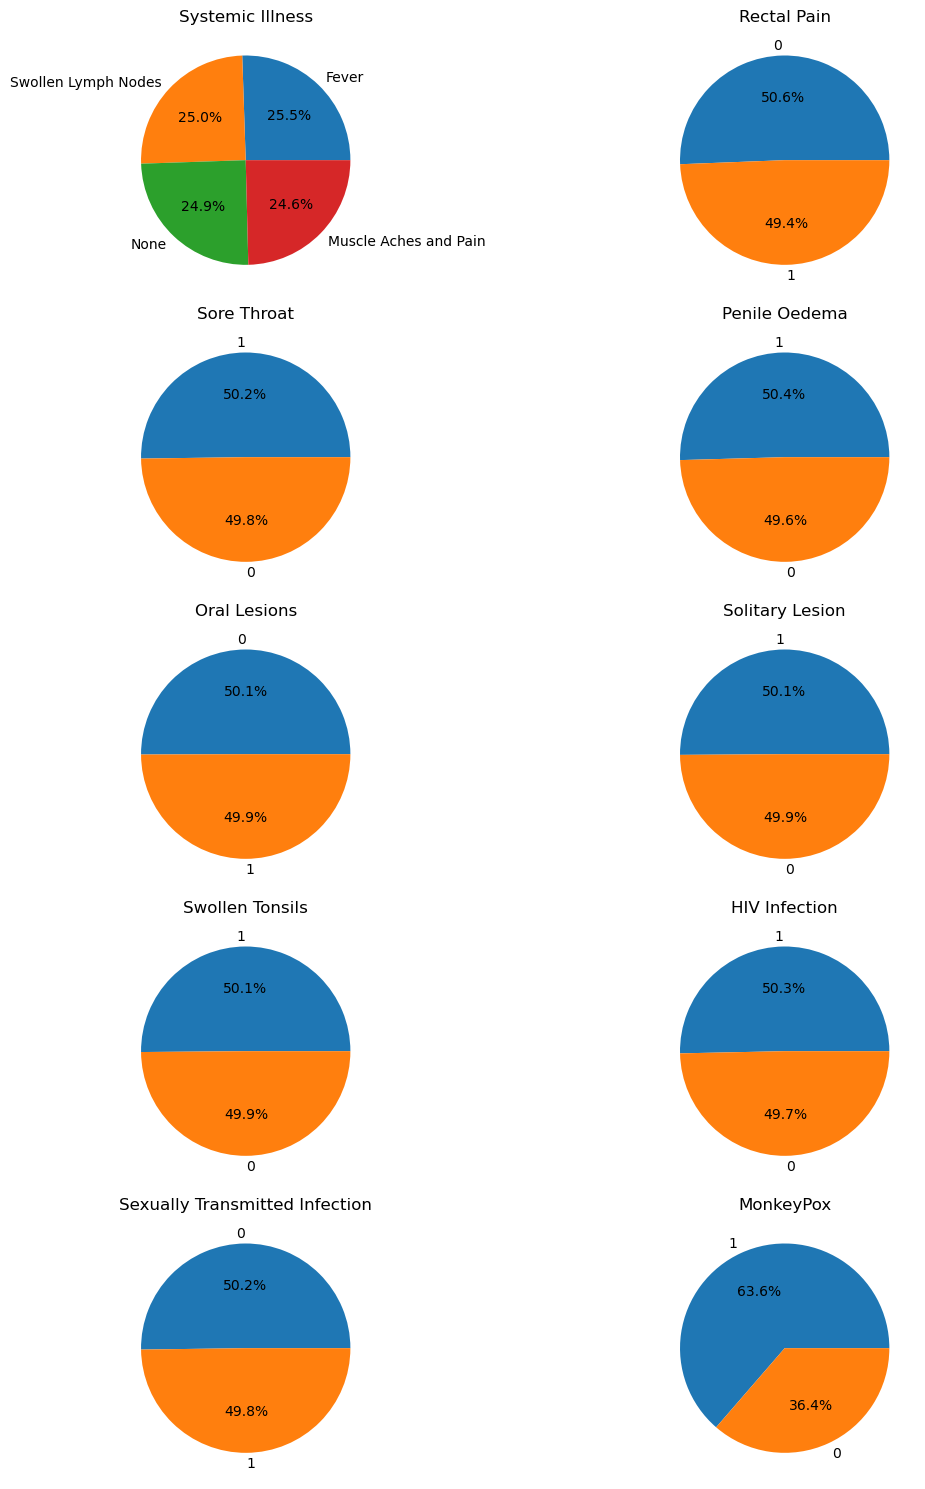

In [24]:
feature_list = list(df.columns)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
for i, feature in enumerate(feature_list):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    value_counts = df[feature].value_counts()
    ax.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
    ax.set_title(feature_list[i])
plt.tight_layout()
plt.show()

In [26]:

print("Class distribution before ADASYN:", Counter(df_Y))

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority')
X_resampled, y_resampled = adasyn.fit_resample(df_X_final, df_Y)

Class distribution before ADASYN: Counter({1: 15909, 0: 9091})


In [29]:
print("Class distribution after ADASYN:\n", y_resampled.value_counts())


Class distribution after ADASYN:
 0    16232
1    15909
Name: MonkeyPox, dtype: int64


<AxesSubplot:ylabel='MonkeyPox'>

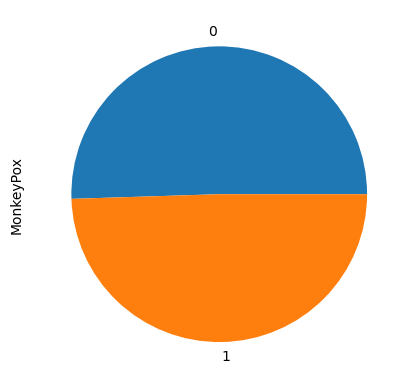

In [30]:
y_resampled.value_counts().plot(kind="pie")

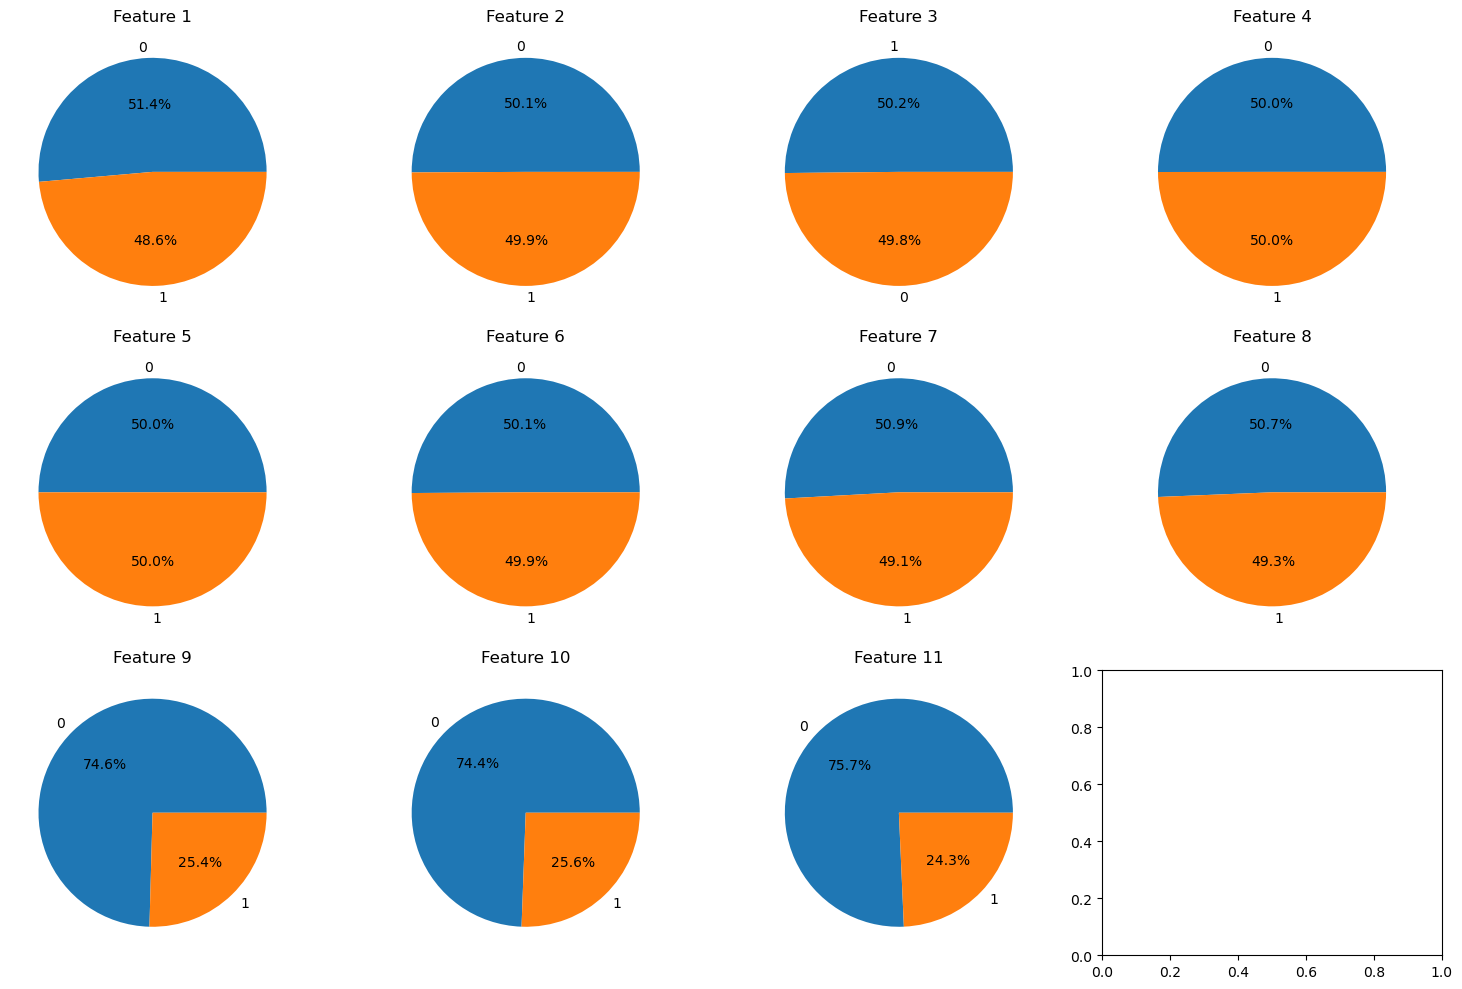

In [31]:
# Create subplots in a 3x4 grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

# Iterate over features and plot pie charts
for i, feature in enumerate(X_resampled.columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Calculate percentages for each category
    percentages = X_resampled[feature].value_counts(normalize=True) * 100

    # Create pie chart using Matplotlib
    ax.pie(percentages.values, labels=percentages.index, autopct='%1.1f%%')
    ax.set_title(f'Feature {i+1}')

plt.tight_layout()
plt.show()

In [46]:
def scores(actual, predicted):
    score = f1_score(actual, predicted)
    recall = recall_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    print('precision：', precision * 100)
    print('accuracy：', accuracy * 100)
    print('recall：', recall * 100)
    print("F1: ", score * 100)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_X_final, df_Y, test_size=0.2, random_state=True)

# Hyper-tuning

In [51]:
models = {
    "DecisionTree": (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],       
        'max_depth': [None, 5, 20, 75],    
        'min_samples_split': [2, 5, 10],
    }),
    "KNeighbors": (KNeighborsClassifier(), {
        'n_neighbors': [13, 15, 27, 39], 
        'weights': ['uniform', 'distance'],    
        'metric': ['euclidean', 'manhattan'],
    }),
    "LogisticRegression": (LogisticRegression(max_iter=10000), {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.01, 0.1, 1, 10],                      
        'solver': ['saga', 'lbfgs', 'liblinear'],     
    }),
}

In [52]:
for model_name, (model, param_grid) in models.items():
    print("************************************************************")
    print(f"\n--- Hyperparameter Tuning for {model_name} ---")
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
    
    # Fit the model with grid search
    grid_search.fit(X_train, y_train)
    
    # Print best parameters and cross-validation accuracy
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)
    
    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_pred = best_model.predict(X_train)
    print("Trainng Accuracy : ",accuracy_score(y_train,train_pred))
    print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred))
    scores(y_test,y_pred)

************************************************************

--- Hyperparameter Tuning for DecisionTree ---
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.6873
Trainng Accuracy :  0.6882

Test Set Accuracy: 0.6862
precision： 70.00481463649496
accuracy： 68.62
recall： 90.00309501702259
F1:  78.75423155044008
************************************************************

--- Hyperparameter Tuning for KNeighbors ---
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 39, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.6808
Trainng Accuracy :  0.6986

Test Set Accuracy: 0.685
precision： 70.58677274987568
accuracy： 68.5
recall： 87.86753327143299
F1:  78.28484764924859
************************************************************

--- Hyperparameter Tuning for LogisticRegression ---
Fitting 10

In [110]:
dt = DecisionTreeClassifier(max_depth=50, min_samples_leaf=50)

In [111]:
dt.fit(X_train, y_train)
y_pred=dt.predict(X_test)
train_pred=dt.predict(X_train)

In [112]:
print("Trainng Accuracy : ",accuracy_score(y_train,train_pred))
print("Testing Accuracy : ",accuracy_score(y_test,y_pred))
scores(y_test,y_pred)

Trainng Accuracy :  0.6965
Testing Accuracy :  0.69
precision： 70.72749691738595
accuracy： 69.0
recall： 88.76508820798514
F1:  78.7263244578644


In [113]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)
train_pred=lr.predict(X_train)

In [114]:
print("Trainng Accuracy : ",accuracy_score(y_train,train_pred))
print("Testing Accuracy : ",accuracy_score(y_test,y_pred))
scores(y_test,y_pred)

Trainng Accuracy :  0.6901
Testing Accuracy :  0.6966
precision： 72.30609057782405
accuracy： 69.66
recall： 85.97957288765087
F1:  78.55224091616003


In [131]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
train_pred=knn.predict(X_train)

C:\Users\dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\dell\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [132]:
print("Trainng Accuracy : ",accuracy_score(y_train,train_pred))
print("Testing Accuracy : ",accuracy_score(y_test,y_pred))
scores(y_test,y_pred)

Trainng Accuracy :  0.70185
Testing Accuracy :  0.6738
precision： 70.58672156459083
accuracy： 67.38
recall： 84.89631692974311
F1:  77.08304060699734
